## Derivation of propagation speed of a spike propagating through a 1D chain of excitatory neurons coupled to recurrent inhibition

In [116]:
%matplotlib inline

from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib
import numpy as np
from scipy import stats
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
from ntwk import LIFNtwkI
from aux import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import functools
from functools import partial
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [117]:
def map_to_list(func, l):
    '''
    Maps the list 'l' through the function 'func'
    Parameters
    ----------
    func : function
        Takes a single argument of type of 'l'
    l : list
    '''
    return list(map(func, l))

def reduce_mult(l):
    return functools.reduce(lambda e1, e2: e1 * e2, l, 1)

# multidimensional generalization of a cartesian proces
# given [2, 4, 6] and [2, 5, 8, 9] generates
# [[2, 2, 2, 2, 4, 4, 4, 4, 6, 6, 6, 6], [2, 5, 8, 9, 2, 5, 8, 9, 2, 5, 8, 9]]
def cartesian(*arrs):
    domain = map_to_list(lambda a: len(a), arrs)
    coordinate_lists = []
    for i, dim in enumerate(domain):
        coords = []
        mult = 1
        if i != len(domain) - 1:
            mult = reduce_mult(domain[i+1:])
        for e in arrs[i]:
            coords += (mult * [e])
        repeat_factor = reduce_mult(domain[0:i])
        if repeat_factor > 0:
            coords *= repeat_factor
        coordinate_lists.append(coords)
    return coordinate_lists

def set_font_size(ax, font_size, legend_font_size=None):
    """Set font_size of all axis text objects to specified value."""

    texts = [ax.title, ax.xaxis.label, ax.yaxis.label] + \
        ax.get_xticklabels() + ax.get_yticklabels()

    for text in texts:
        text.set_fontsize(font_size)

    if ax.get_legend():
        if not legend_font_size:
            legend_font_size = font_size
        for text in ax.get_legend().get_texts():
            text.set_fontsize(legend_font_size)

### Calculation of stable values of p for different values of recurrent inhibition

In [118]:
dt = 5e-5
tau_m_e = 4e-3
tau_m_i = 4e-3
tau_a = 1.6e-3
v_th_e = 20e-3
v_th_i = 20e-3
c_e = 1e-6
c_i = 1e-6
f_e = 130

w_ee = 2.4e-4
w_ei = 0.5e-5
w_ie = -3e-5

In [119]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=0.5e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=250,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=0,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = w_ee,
    W_E_I = w_ei, #0.2e-5, #1e-5,
    W_I_E = w_ie,
    W_U_E = 0,
    W_U_I = 0, #1e-1,
    
    F_IN = 500,
    SIGMA_IN = 10e-3,
    
    F_B = 5e3,
    T_B = 15e-3,
)

tau_m = 10e-3

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

In [120]:
def calc_t_d(t_b_in, t_d_in, params):
    p = params
    return p['tau_e'] * np.log(1 / (1 - (p['v_th'] - p['tau_e'] * p['tau_i'] * p['w_r'] * t_b_in / t_d_in) / p['w_ee']))
    
def calc_t_b(t_b_in, t_d_in, t_d_out, params):
    p = params
    log_numerator = p['v_th'] - p['tau_e'] * p['tau_i'] * p['w_r'] * t_b_in / t_d_in
    log_denominator = p['w_ee'] * (1 - np.exp(-t_b_in / p['tau_e']))
    return p['tau_e'] * np.log(log_denominator / log_numerator) + t_b_in - t_d_out

def calc_out(t_b_in, t_d_in, params):
    p = params
    t_d_out = calc_t_d(t_b_in, t_d_in, p)
    t_b_out = calc_t_b(t_b_in, t_d_in, t_d_out, p)
    return t_b_out, t_d_out

In [164]:
def fixed_t_d_from_t_b(t_b, params):
    p = params
    return p['tau_e'] * np.log(2 - np.exp(-t_b / p['tau_e']))

def solve_attractor(t_b, params):
    p = params
    exp_t_b = np.exp(-t_b / p['tau_e'])
    return (p['v_th'] / p['tau_e'] - p['w_ee'] * ((1 - exp_t_b) / (2 - exp_t_b))) * np.power(fixed_t_d_from_t_b(t_b, p), p['alpha']) - p['w_r'] * np.power(t_b, p['alpha'])

In [165]:
def solve_attractor_wrapper(params, guess=20e-3):
    p = params
    f = partial(solve_attractor, params=p)
    sol = fsolve(f, guess, maxfev=10000)
    if len(sol) > 1:
        print(f'{len(sol)} solutions found')
    if np.isclose(f(sol[0]), 0.):
        t_b = sol[0]
        t_d = fixed_t_d_from_t_b(t_b, p)
        return t_b, t_d
    else:
        return np.nan, np.nan

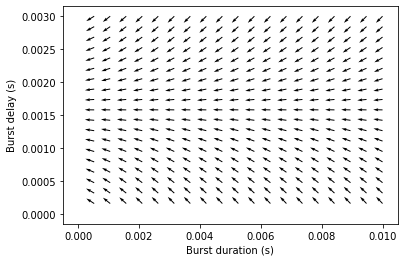

In [158]:
params = {
    'tau_e': 1e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': 0,
    'w_ee': 0.05,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 10e-3, 20), np.linspace(0, 3e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.xlabel('Burst duration (s)')
plt.ylabel('Burst delay (s)')
plt.show()

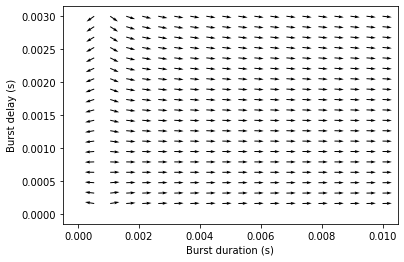

In [157]:
params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': 0,
    'w_ee': 0.6,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 10e-3, 20), np.linspace(0, 3e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.xlabel('Burst duration (s)')
plt.ylabel('Burst delay (s)')
plt.show()

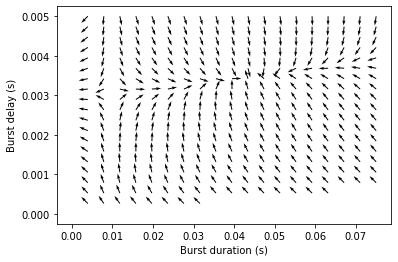

(0.04328234198209288, 0.0034653008895914744)

In [73]:
params = {
    'tau_e': 5e-3,
    'tau_i': 4e-3,
    'v_th': 0.04,
    'w_r': -20,
    'w_ee': 0.09,
}

t_b_in, t_d_in = np.meshgrid(np.linspace(0, 75e-3, 20), np.linspace(0, 5e-3, 20))

t_b_out, t_d_out = calc_out(t_b_in, t_d_in, params)

# print(t_d_out)

norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(t_d_out - t_d_in))

plt.quiver(t_b_in, t_d_in, (t_b_out - t_b_in) / norms, (t_d_out - t_d_in) / norms)
plt.xlabel('Burst duration (s)')
plt.ylabel('Burst delay (s)')
plt.show()

solve_attractor_wrapper(params)

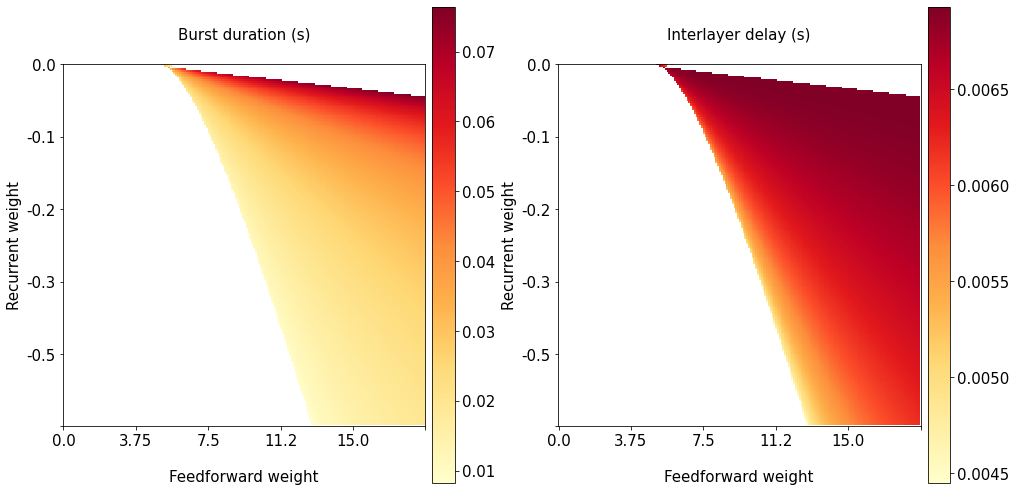

In [187]:
base_params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.02,
    'alpha': 2.,
}
t_b_in, t_d_in = (20e-3, 3e-3)

w_ee_val_range = (0, 15)
w_r_val_range = (0, -0.5)
n_steps = 200

w_ee, w_r = np.meshgrid(
    np.linspace(w_ee_val_range[0], w_ee_val_range[1], n_steps),
    np.linspace(w_r_val_range[0], w_r_val_range[1], n_steps)
)

t_d_out = np.nan * np.zeros(w_ee.shape)
t_b_out = np.nan * np.zeros(w_ee.shape)

for i in range(len(w_ee)):
    for j in range(len(w_ee[0])):
        params = copy(base_params)
        params['w_ee'] = w_ee[i][j]
        params['w_r'] = w_r[i][j]
        t_b_stable, t_d_stable = solve_attractor_wrapper(params, guess=30e-3)
        
        if ~np.isclose(t_b_stable, 0):
            t_b_out[i][j] = t_b_stable
            t_d_out[i][j] = t_d_stable

# t_d_out = np.where(t_b_out < 0.03, t_d_out, np.nan)
# t_b_out = np.where(t_b_out < 0.03, t_b_out, np.nan)

scale = 7
cbar_frac = 0.1
fig = plt.figure(constrained_layout=True, figsize=(2 * scale, scale))
graph_col_width = int(1 / cbar_frac)
gs = gridspec.GridSpec(ncols=2 * graph_col_width, nrows=1, figure=fig)
axs = [
    fig.add_subplot(gs[0: graph_col_width - 1]),
    fig.add_subplot(gs[graph_col_width - 1]),
    fig.add_subplot(gs[graph_col_width: 2 * graph_col_width - 1]),
    fig.add_subplot(gs[2 * graph_col_width - 1]),
]

im1 = axs[0].matshow(t_b_out, cmap='YlOrRd')
im2 = axs[2].matshow(t_d_out, cmap='YlOrRd')

axs[0].set_title('Burst duration (s)')
axs[2].set_title('Interlayer delay (s)')

plt.colorbar(im1, cax=axs[1])
plt.colorbar(im2, cax=axs[3])

for i in range(0, 4, 2):
    axs[i].set_ylabel('Recurrent weight')
    axs[i].set_xlabel('\nFeedforward weight')
    axs[i].set_xticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_xticklabels([f'{d}'[:4] for d in np.linspace(w_ee_val_range[0], w_ee_val_range[1], 5)])
    axs[i].set_yticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_yticklabels([f'{d}'[:4] for d in np.linspace(w_r_val_range[0], w_r_val_range[1], 5)])
    axs[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    
for i in range(0, 4):
    set_font_size(axs[i], 15)

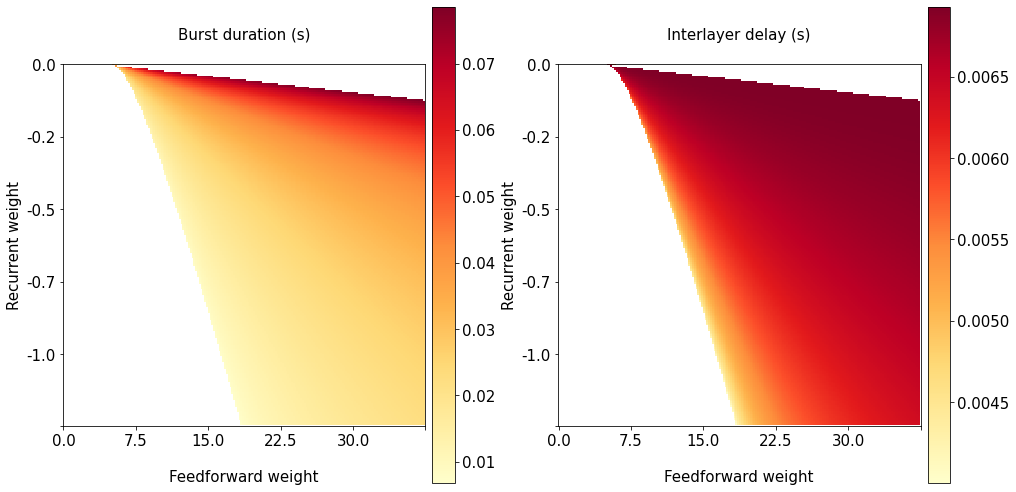

In [188]:
base_params = {
    'tau_e': 10e-3,
    'tau_i': 4e-3,
    'v_th': 0.02,
    'alpha': 2.,
}
t_b_in, t_d_in = (20e-3, 3e-3)

w_ee_val_range = (0, 30)
w_r_val_range = (0, -1)
n_steps = 200

w_ee, w_r = np.meshgrid(
    np.linspace(w_ee_val_range[0], w_ee_val_range[1], n_steps),
    np.linspace(w_r_val_range[0], w_r_val_range[1], n_steps)
)

t_d_out = np.nan * np.zeros(w_ee.shape)
t_b_out = np.nan * np.zeros(w_ee.shape)

for i in range(len(w_ee)):
    for j in range(len(w_ee[0])):
        params = copy(base_params)
        params['w_ee'] = w_ee[i][j]
        params['w_r'] = w_r[i][j]
        t_b_stable, t_d_stable = solve_attractor_wrapper(params, guess=30e-3)
        
        if ~np.isclose(t_b_stable, 0):
            t_b_out[i][j] = t_b_stable
            t_d_out[i][j] = t_d_stable

# t_d_out = np.where(t_b_out < 0.03, t_d_out, np.nan)
# t_b_out = np.where(t_b_out < 0.03, t_b_out, np.nan)

scale = 7
cbar_frac = 0.1
fig = plt.figure(constrained_layout=True, figsize=(2 * scale, scale))
graph_col_width = int(1 / cbar_frac)
gs = gridspec.GridSpec(ncols=2 * graph_col_width, nrows=1, figure=fig)
axs = [
    fig.add_subplot(gs[0: graph_col_width - 1]),
    fig.add_subplot(gs[graph_col_width - 1]),
    fig.add_subplot(gs[graph_col_width: 2 * graph_col_width - 1]),
    fig.add_subplot(gs[2 * graph_col_width - 1]),
]

im1 = axs[0].matshow(t_b_out, cmap='YlOrRd')
im2 = axs[2].matshow(t_d_out, cmap='YlOrRd')

axs[0].set_title('Burst duration (s)')
axs[2].set_title('Interlayer delay (s)')

plt.colorbar(im1, cax=axs[1])
plt.colorbar(im2, cax=axs[3])

for i in range(0, 4, 2):
    axs[i].set_ylabel('Recurrent weight')
    axs[i].set_xlabel('\nFeedforward weight')
    axs[i].set_xticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_xticklabels([f'{d}'[:4] for d in np.linspace(w_ee_val_range[0], w_ee_val_range[1], 5)])
    axs[i].set_yticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_yticklabels([f'{d}'[:4] for d in np.linspace(w_r_val_range[0], w_r_val_range[1], 5)])
    axs[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    
for i in range(0, 4):
    set_font_size(axs[i], 15)

In [98]:
def solve_attractor_burst(t_d, params):
    p = params
    return t_d + p['tau_e'] * np.log(1. - (p['v_th'] / p['tau_e'] - p['w_r'] * p['t_b'] / t_d) / p['w_ee'])

def solve_attractor_burst_wrapper(params, guess=20e-3):
    p = params
    f = partial(solve_attractor_burst, params=p)
    sol = fsolve(f, guess, maxfev=10000)
    if len(sol) > 1:
        print(f'{len(sol)} solutions found')
    if np.isclose(f(sol[0]), 0.):
        t_d = sol[0]
        return t_d
    else:
        return np.nan

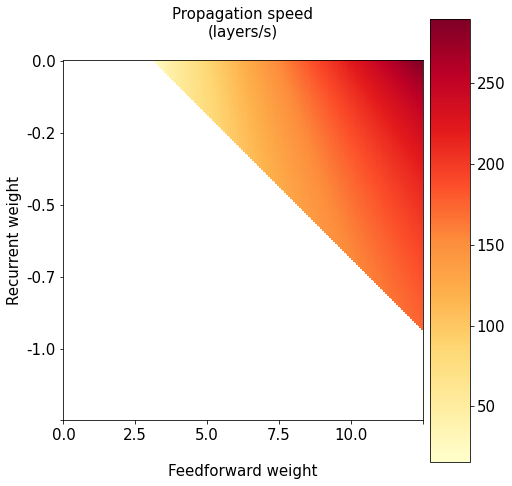

In [115]:
base_params = {
    'tau_e': 12e-3,
    'tau_i': 4e-3,
    'v_th': 0.03,
    't_b': 0.01,
}
t_b_in, t_d_in = (10e-3, 1e-3)

w_ee_val_range = (0, 10)
w_r_val_range = (0, -1)
n_steps = 200

w_ee, w_r = np.meshgrid(
    np.linspace(w_ee_val_range[0], w_ee_val_range[1], n_steps),
    np.linspace(w_r_val_range[0], w_r_val_range[1], n_steps)
)

t_d_out = np.nan * np.zeros(w_ee.shape)

for i in range(len(w_ee)):
    for j in range(len(w_ee[0])):
        params = copy(base_params)
        params['w_ee'] = w_ee[i][j]
        params['w_r'] = w_r[i][j]
        t_d_stable = solve_attractor_burst_wrapper(params, guess=1e-3)
        
#         if ~np.isclose(t_d_stable, 0):
        t_d_out[i][j] = t_d_stable

# t_d_out = np.where(t_b_out < 0.05, t_d_out, 0)
# t_b_out = np.where(t_b_out < 0.05, t_b_out, 0)

scale = 7
cbar_frac = 0.1
fig = plt.figure(constrained_layout=True, figsize=(scale, scale))
graph_col_width = int(1 / cbar_frac)
gs = gridspec.GridSpec(ncols=graph_col_width, nrows=1, figure=fig)
axs = [
    fig.add_subplot(gs[0: graph_col_width - 1]),
    fig.add_subplot(gs[graph_col_width - 1]),
]

im1 = axs[0].matshow(1/t_d_out, cmap='YlOrRd')

axs[0].set_title('Propagation speed\n(layers/s)')

plt.colorbar(im1, cax=axs[1])

for i in range(0, 2, 2):
    axs[i].set_ylabel('Recurrent weight')
    axs[i].set_xlabel('\nFeedforward weight')
    axs[i].set_xticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_xticklabels([f'{d}'[:4] for d in np.linspace(w_ee_val_range[0], w_ee_val_range[1], 5)])
    axs[i].set_yticks(np.arange(0, n_steps + 1, int(n_steps / 5)))
    axs[i].set_yticklabels([f'{d}'[:4] for d in np.linspace(w_r_val_range[0], w_r_val_range[1], 5)])
    axs[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    
for i in range(0, 2):
    set_font_size(axs[i], 15)